In [119]:
# Load main packages
import pandas as pd
import numpy as np
import re # Regular expressions
import seaborn as sns
import matplotlib.pyplot as plt
import getpass # For identifying user/directory structure
from sklearn import linear_model
%matplotlib inline

# Load local files
import sys # For reading files in other directories
if(getpass.getuser() == '?'):
    sys.path.insert(0, 'C:/Users/rockc_000/Documents/GitHub/GithubSandbox/Python/NCAA Scripts')
    dir = 'C:/Users/rockc_000/Documents/Personal Files/Kaggle/NCAA'
if(getpass.getuser() == 'josh'):
    sys.path.insert(0, '/home/josh/Documents/Github/GithubSandbox/Python/NCAA Scripts')
    dir = '/home/josh/Documents/Personal/Kaggle/NCAA'
from make_submission import make_submission

In [14]:
# Read in data
seasons = pd.read_csv(dir + '/Seasons.csv')
teams = pd.read_csv(dir + '/Teams.csv')
regular_compact_results = pd.read_csv(dir + '/RegularSeasonCompactResults.csv')
regular_detailed_results = pd.read_csv(dir + '/RegularSeasonDetailedResults.csv')
tourney_compact_results = pd.read_csv(dir + '/TourneyCompactResults.csv')
tourney_detailed_results = pd.read_csv(dir + '/TourneyDetailedResults.csv')
tourney_seed = pd.read_csv(dir + '/TourneySeeds.csv')
tourney_slots = pd.read_csv(dir + '/TourneySlots.csv')
sample_submission = pd.read_csv(dir + '/SampleSubmission.csv')

In [15]:
# Look at the first few rows of each dataset, and their dimensions
# sample_submission.iloc[np.arange(5)]
nrow = 4
print('seasons:\n', seasons.head(nrow), '\nDimension: ', seasons.shape)
print('teams:\n', teams.head(nrow), '\nDimension: ', teams.shape)
print('regular_compact_results:\n', regular_compact_results.head(nrow),
      '\nDimension: ', regular_compact_results.shape)
print('regular_detailed_results:\n', regular_detailed_results.head(nrow),
      '\nDimension: ', regular_detailed_results.shape)
print('tourney_compact_results:\n', tourney_compact_results.head(nrow),
      '\nDimension: ', tourney_compact_results.shape)
print('tourney_detailed_results:\n', tourney_detailed_results.head(nrow),
      '\nDimension: ', tourney_detailed_results.shape)
print('tourney_seed:\n', tourney_seed.head(nrow),
      '\nDimension: ', tourney_seed.shape)
print('tourney_slots:\n', tourney_slots.head(nrow),
      '\nDimension: ', tourney_slots.shape)
print('sample_submission:\n', sample_submission.head(nrow),
      '\nDimension: ', sample_submission.shape)

seasons:
    Season     Dayzero Regionw    Regionx    Regiony    Regionz
0    1985  10/29/1984    East       West    Midwest  Southeast
1    1986  10/28/1985    East    Midwest  Southeast       West
2    1987  10/27/1986    East  Southeast    Midwest       West
3    1988  11/02/1987    East    Midwest  Southeast       West 
Dimension:  (32, 6)
teams:
    Team_Id    Team_Name
0     1101  Abilene Chr
1     1102    Air Force
2     1103        Akron
3     1104      Alabama 
Dimension:  (364, 2)
regular_compact_results:
    Season  Daynum  Wteam  Wscore  Lteam  Lscore Wloc  Numot
0    1985      20   1228      81   1328      64    N      0
1    1985      25   1106      77   1354      70    H      0
2    1985      25   1112      63   1223      56    H      0
3    1985      25   1165      70   1432      54    H      0 
Dimension:  (139920, 8)
regular_detailed_results:
    Season  Daynum  Wteam  Wscore  Lteam  Lscore Wloc  Numot  Wfgm  Wfga ...   \
0    2003      10   1104      68   1328      6

In [16]:
# Test make_submission function
data = [re.split('_', id) for id in sample_submission['Id']]
data = pd.DataFrame(data)
data.columns = ['Year', 'team_id1', 'team_id2']
data['Pred'] = sample_submission['Pred']

equal_pred = make_submission(data, 'equal_preds.csv')

In [17]:
regular_compact_results.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [18]:
# Simple pred based on historical winning
# Convert regular_compact_results into a Dataframe with
# columns season, team, win/lose indicator.
wins = regular_compact_results[['Season', 'Wteam']]
wins.columns = ('Season', 'Team')
wins.loc[:, 'Status'] = 'Win'
losses = regular_compact_results[['Season', 'Lteam']]
losses.columns = ('Season', 'Team')
losses.loc[:, 'Status'] = 'Loss'
results = wins.copy()
results = results.append(losses)
results.head()

/home/josh/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/josh/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Season,Team,Status
0,1985,1228,Win
1,1985,1106,Win
2,1985,1112,Win
3,1985,1165,Win
4,1985,1192,Win


In [19]:
grp = results.groupby(('Season', 'Team'), as_index = False)
def agg_fun(x):
    return(np.mean(x == 'Win'))
average_wins = grp.agg(agg_fun)
average_wins.head()

,Season,Team,Status
0,1985,1102,0.208333
1,1985,1103,0.391304
2,1985,1104,0.700000
3,1985,1106,0.416667
4,1985,1108,0.760000


In [20]:
# Convert types so we can do a merge
average_wins['Season'] = average_wins['Season'].astype(int)
average_wins['Team'] = average_wins['Team'].astype(int)
prob_dataset = pd.merge(data, average_wins, left_on = ('Year', 'team_id1'), right_on = ('Season', 'Team'))
prob_dataset.rename(columns = {'Status': 'Prob_team_1'}, inplace = True)
prob_dataset = pd.merge(prob_dataset, average_wins, left_on = ('Year', 'team_id2'), right_on = ('Season', 'Team'))
prob_dataset.rename(columns = {'Status': 'Prob_team_2'}, inplace = True)
prob_dataset.head()
prob_dataset['Pred'] = prob_dataset['Prob_team_1'] / (prob_dataset['Prob_team_1'] + prob_dataset['Prob_team_2'])
# Score of 0.664337, minor improvement over 0.5 model.
submit2 = make_submission(prob_dataset, 'Simple_probs.csv')

In [113]:
# Another simple model: use a logistic regression model
# against the difference in seed (and maybe other variables) to predict the probability.

# Merge in probabilities
data = tourney_compact_results.ix[:, ('Season', 'Wteam', 'Wscore', 'Lteam', 'Lscore')]
data = pd.merge(data, average_wins, left_on=('Season', 'Wteam'), right_on=('Season', 'Team'))
data.rename(columns={'Status': 'Wprob'}, inplace=True)
data.drop('Team', axis=1, inplace=True)
data = pd.merge(data, average_wins, left_on=('Season', 'Lteam'), right_on=('Season', 'Team'))
data.rename(columns={'Status': 'Lprob'}, inplace=True)
data.drop('Team', axis=1, inplace=True)

# Merge in seeds
data = pd.merge(data, tourney_seed, left_on=('Season', 'Wteam'), right_on=('Season', 'Team'))
data.rename(columns={'Seed': 'Wseed'}, inplace=True)
data.drop('Team', axis=1, inplace=True)
data = pd.merge(data, tourney_seed, left_on=('Season', 'Lteam'), right_on=('Season', 'Team'))
data.rename(columns={'Seed': 'Lseed'}, inplace=True)
data.drop('Team', axis=1, inplace=True)

# Define dependent variable: larger team won.  Arbitrary, but
# allows us a reference point.
data['Larger_id_win'] = data['Wteam'] > data['Lteam']
# Bteam is the team with the bigger id.  Steam is the team with the smaller id.
data['Bteam'] = data.ix[:, ('Wteam', 'Lteam')].max(axis=1)
data['Steam'] = data.ix[:, ('Wteam', 'Lteam')].min(axis=1)
data['Bprob'] = data['Wprob']
data.loc[data['Bteam'] == data['Lteam'], 'Bprob'] = \
    data.loc[data['Bteam'] == data['Lteam'], 'Lprob']
data['Sprob'] = data['Lprob']
data.loc[data['Bteam'] == data['Lteam'], 'Sprob'] = \
    data.loc[data['Bteam'] == data['Lteam'], 'Wprob']
data['Bseed'] = data['Wseed']
data.loc[data['Bteam'] == data['Lteam'], 'Bseed'] = \
    data.loc[data['Bteam'] == data['Lteam'], 'Lseed']
data['Sseed'] = data['Lseed']
data.loc[data['Bteam'] == data['Lteam'], 'Sseed'] = \
    data.loc[data['Bteam'] == data['Lteam'], 'Wseed']

# Compute difference in seeds.  Difference should be larger id
# minus smaller id, so multiply by -1 if the smaller id won.
data['Seed_diff'] = (np.array([int(x[1:3]) for x in data['Bseed']]) -\
                     np.array([int(x[1:3]) for x in data['Sseed']]))

# Create a few predictor variables.
data['Prob_ratio'] = (data['Bprob'] / data['Sprob'])
data['log_Prob_ratio'] = np.log(data['Prob_ratio'])
data['Prob_wtd_mean'] = data['Bprob'] / (data['Bprob'] + data['Sprob'])

# Filter model data to just known years
model_data = data[data['Season'] < 2012]
model_data.head()

,Season,Wteam,Wscore,Lteam,Lscore,Wprob,Lprob,Wseed,Lseed,Larger_id_win,Bteam,Steam,Bprob,Sprob,Bseed,Sseed,Seed_diff,Prob_ratio,log_Prob_ratio,Prob_wtd_mean
0,1985,1116,63,1234,54,0.636364,0.666667,X09,X08,False,1234,1116,0.666667,0.636364,X08,X09,-1,1.047619,0.046520,0.511628
1,1985,1120,59,1345,58,0.620690,0.680000,Z11,Z06,False,1345,1120,0.680000,0.620690,Z06,Z11,-5,1.095556,0.091262,0.522800
2,1985,1120,66,1242,64,0.620690,0.766667,Z11,Z03,False,1242,1120,0.766667,0.620690,Z03,Z11,-8,1.235185,0.211221,0.552610
3,1985,1207,68,1250,43,0.925926,0.379310,W01,W16,False,1250,1207,0.379310,0.925926,W16,W01,15,0.409655,-0.892440,0.290607
4,1985,1207,63,1396,46,0.925926,0.827586,W01,W08,False,1396,1207,0.827586,0.925926,W08,W01,7,0.893793,-0.112281,0.471959


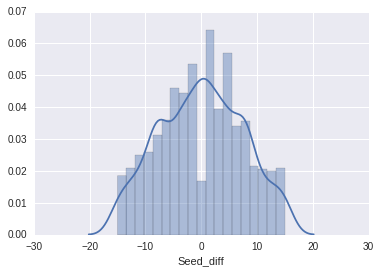

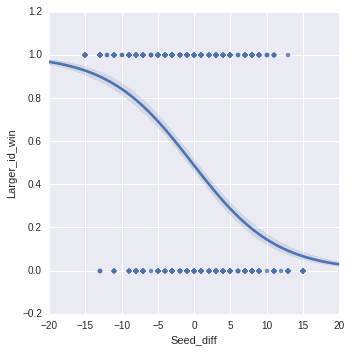

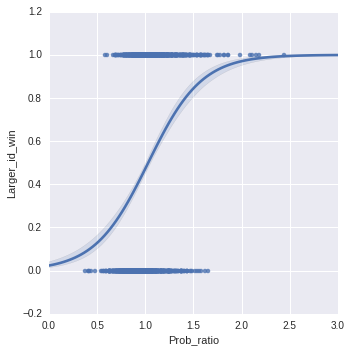

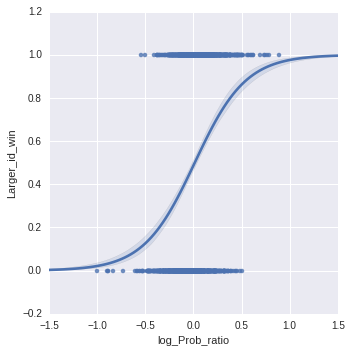

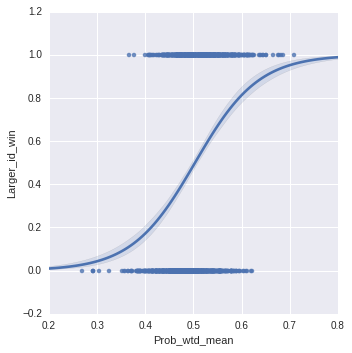

In [114]:
sns.distplot(data['Seed_diff'])
sns.lmplot(x='Seed_diff', y='Larger_id_win', data=model_data,
           logistic=True)
sns.lmplot(x='Prob_ratio', y='Larger_id_win', data=model_data,
           logistic=True)
sns.lmplot(x='log_Prob_ratio', y='Larger_id_win', data=model_data,
           logistic=True)
sns.lmplot(x='Prob_wtd_mean', y='Larger_id_win', data=model_data,
           logistic=True)

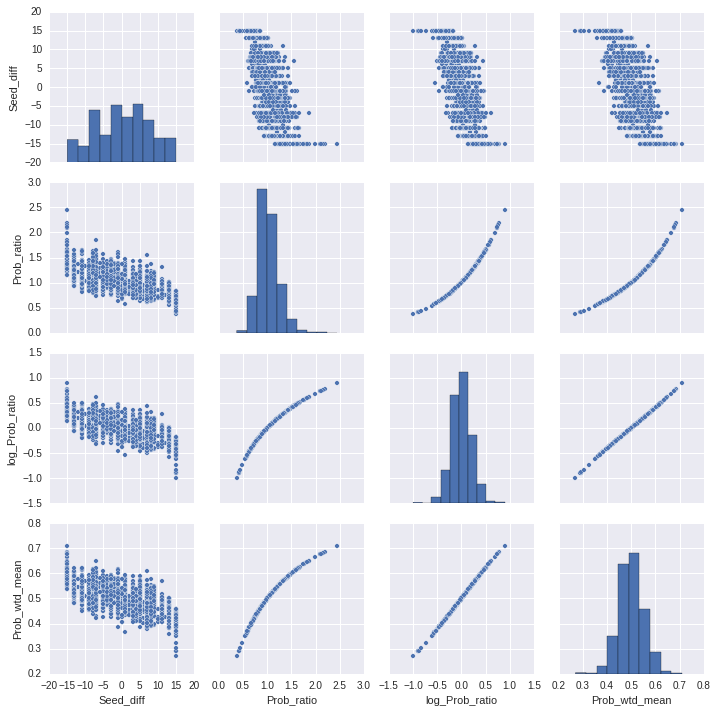

In [116]:
sns.pairplot(data = model_data, vars=('Seed_diff', 'Prob_ratio',
                                      'log_Prob_ratio', 'Prob_wtd_mean'))

In [127]:
# Let's do a logistic regression, but use LASSO to reduce coefficients to zero.
lasso = linear_model.Lasso()
lasso.fit(X=model_data.ix[:, ('Seed_diff', 'Prob_ratio',
                              'log_Prob_ratio', 'Prob_wtd_mean')],
         y=model_data['Larger_id_win'])
print(lasso.coef_)
print(lasso.intercept_)

[-0.01632904  0.          0.          0.        ]
0.488875000618


In [123]:
# Now time for some data exploration
# Let's plot season statistics against tourney performance
